In [1]:
import networkx as nx
import pandas as pd

In [2]:
import numpy as np
from random import random

In [407]:
class Tournament(object):
    def __init__(self):
        # team Data
        self.team_dict = {}
        # Completed fixture Data
        self.fixture_list = []
        # Pending fixture Data
        self.pending_fixture_list = []
        # Default seed
        self.max_seed = 0
        # Points for a win
        self.win_pts = 3
        #Points for a draw
        self.draw_pts = 1
        #Points for a bye
        self.bye_pts = 3
        # Matchday Count
        self.matchday = 0
        # Minimum Possible Pairings
        self.min_pairings = 20
        # Tiebreaker
        self.tiebreaker = 'sonneborn-berger'
        # Whether to consider home and away
        self.home_away = True
        # Maximum number of meetings
        self.max_meetings = 1
        # Dummy variable for testing
        # self.dummy_variable = []
        # Filter Category allocation for hybrid fixtures
        self.allocation = {}
        
    
    def add_team(self, name, seed = 'none', points = 0, more = {}):
        if seed == 'none':
            seed = self.max_seed
        
        self.team_dict[name] = {'seed': seed,
                                 'points': points,
                                 'opponents': [],
                                'home_away': [],
                                'home_away_restriction': None,
                                'home_away_gap': 0,
                                 'byes': 0, 
                                'sonneborn-berger': 0}
        
        self.team_dict[name].update(more)
        
    def teams_df(self):
        df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points','seed'], 
                                                                                   ascending = [False,True]).reset_index(names = 'name')
        return df
    
    # Pair all teams with no extra restrictions
    def all_fixtures(self):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        self.create_fixtures(teams_df)
    
    # Pair all teams with one filter
    def filtered_fixtures(self, filter_):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in teams_df[filter_].drop_duplicates()]
        for teams in teams_divided:
            self.create_fixtures(teams)
            
    def hybrid_fixtures(self, filter_):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        filter_categories =  teams_df[filter_].drop_duplicates()
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in filter_categories]
        
        # Sort teams into top tier and filter other teams
        top_teams = []
        other_teams = []
        for table, category in zip(teams_divided, filter_categories):
            allocation = self.allocation[category]
            top_teams.append(table[:allocation])
            other_teams.append(table[allocation:].reset_index(drop = True))
        top_tier_teams = pd.concat(top_teams).sort_values(by = ['points','seed'], ascending = [False,True]).reset_index(drop = True)
        
        # Create fixtures
        self.create_fixtures(top_tier_teams, avoid_same_country = 2)
        for teams in other_teams:
            self.create_fixtures(teams)
    
    def final_fixtures(self, filter_, gap_cutoff):
        self.matchday += 1
        teams_df = self.teams_df()
        continent_leader = teams_df.points[0]
        
        # Divide teams into top and low tiers
        top_teams_count = sum(continent_leader - teams_df.points <= gap_cutoff)
        if top_teams_count % 2 == 1:
            if top_teams_count == 1:
                top_teams_count = 0
            top_teams_count += 1
        
        top_tier_teams = teams_df[:top_teams_count]
        low_tier_teams = teams_df[top_teams_count:]
        
        # Divide and filter low tier teams
        national_leaders = list(teams_df.drop_duplicates(filter_).points)

        filter_categories =  teams_df[filter_].drop_duplicates().reset_index(drop = True)
        teams_divided = [low_tier_teams[low_tier_teams[filter_] == x].reset_index(drop=True) for x in filter_categories]

        for idx, table in enumerate(teams_divided):
            allocation = sum(national_leaders[idx] - table.points <= gap_cutoff)
            if allocation % 2 == 1:
                if (filter_categories[idx] not in top_tier_teams[filter_].values) & (allocation == 1):
                    allocation = 0
                else:
                    allocation += 1
            teams_divided[idx] = table[:allocation].reset_index(drop = True)
        # Create Fixtures
        self.create_fixtures(top_tier_teams, avoid_same_country = 1)
        for teams in teams_divided:
            if len(teams) > 0:
                self.create_fixtures(teams)
        
    def create_fixtures(self, teams_df, avoid_same_country = 0):    
        # Check whether a team needs to be given a bye
        byeNeeded = (len(teams_df) % 2 == 1)
        
        # Create a network graph
        G = nx.Graph()
        
        # Parameters for creating possible pairings
        reach = max(max(teams_df.points.value_counts()), self.min_pairings, self.matchday)
        step = max(int(reach/self.min_pairings), 1)
        
        # Add edges for each pairing of teams
        for idx, data1 in teams_df.iterrows():
            team1 = data1['name']
            options = teams_df[idx + 1 : idx + reach : step]
            
            for idx2, data2 in options.iterrows():
                team2 = data2['name']
                
                ptsGap = abs(data1['points'] - data2['points'])
                seedGap = abs(data1['seed'] - data2['seed'])
                same_country = data1['country'] == data2['country']
                
                # Check home/away restrictions
                home_away_penalty = 0
                restriction1 = data1['home_away_restriction']
                restriction2 = data2['home_away_restriction']
                if (restriction1 == restriction2) & (restriction1 != None):
                    home_team1 = None
                    home_away_penalty += 1
                elif (restriction1 == 'home only') | (restriction2 == 'away only'):
                    home_team1 = team1
                elif (restriction2 == 'home only') | (restriction1 == 'away only'):
                    home_team1 = team2
                else:
                    home_team1 = None
                
                # Check Previous Matches
                previous_matches = max(data1['opponents'].count(team2) + 1 - self.max_meetings, 0)
                
                previous_matches_ha = [data1['home_away'][i] for i, x in enumerate(data1['opponents']) if x == team2]
                if previous_matches_ha.count('home') > previous_matches_ha.count('away'):
                    home_team2 = team2
                elif previous_matches_ha.count('home') < previous_matches_ha.count('away'):
                    home_team2 = team1
                else:
                    home_team2 = None
                
                home_team = None
                if (home_team1 == home_team2) | (home_team1 == None) | (home_team2 == None):
                    for home_team_decider in [home_team1, home_team2]:
                        if home_team_decider != None:
                            home_team = home_team_decider
                    if home_team == None:
                        gap = data1['home_away_gap'] - data2['home_away_gap']
                        if gap < 0:
                            home_team = team1
                        elif gap > 0:
                            home_team = team2
                else:
                    home_away_penalty += 1
                    home_team = team1
                        
                # weights are determined by number of previous matches, 
                # home/away restrictions, same country restrictions, points gap and seed gap
                # a lower weight is better
                values = [previous_matches, 
                          home_away_penalty, 
                          same_country * (avoid_same_country == 2), 
                          ptsGap, 
                          data1['opponents'].count(team2),
                          same_country * (avoid_same_country == 1),
                          -seedGap, 
                          -round(pow(seedGap, 0.5)*10, 0)]
                digits = [1,1,1,2,1,1,3,3,0]
                weight = 0
                for idx, value in enumerate(values):
                    weight += value * pow(10, sum(digits[idx + 1 :]))
                # weight = previous_matches * 1000 + home_away_penalty * 200 + same_country * 100 + ptsGap - seedGap/1000
                
                G.add_edge(team1, team2, weight = weight, home = home_team)
            
            # Calculate bye weights if necessary
            if byeNeeded & (len(teams_df) - idx < 101):
                pts = data1['points']
                seed = data1['seed']
                byes = data1['byes']

                weight = byes * pow(10,sum(digits) + 1) + pts - seed/1000
                G.add_edge(team1,'bye', weight = weight)
            
        # Conduct minumum weight matching
        fixtures = nx.algorithms.matching.min_weight_matching(G)
        
        # Add opponent to each team, and bye count for the team with a bye
        for fixture in fixtures:
            if 'bye' in fixture:
                for team in fixture:
                    if team != 'bye':
                        self.team_dict[team]['byes'] += 1
                        self.team_dict[team]['points'] += self.bye_pts
            else:
                team1, team2 = fixture[0], fixture[1]
                self.team_dict[team1]['opponents'].append(team2)
                self.team_dict[team2]['opponents'].append(team1)
                
                # Deciding which team plays home
                if G[team1][team2]['home'] == team2:
                    final_fixture = (fixture[1], fixture[0])
                    self.team_dict[team2]['home_away'].append('home')
                    self.team_dict[team1]['home_away'].append('away')
                else:
                    final_fixture = fixture
                    self.team_dict[team1]['home_away'].append('home')
                    self.team_dict[team2]['home_away'].append('away')
                                  
                self.pending_fixture_list.append((final_fixture[0], final_fixture[1], self.matchday))
        
    
    def report_result(self, result, more = {}):
        # Result format: {team1: score1, team2: score2}
        
        teams = list(result.keys())
        totals = list(result.values())
        
        # Remove entry in pending fixture list
        for fixture in self.pending_fixture_list:
            if (teams[0] in fixture) & (teams[1] in fixture):
                matchday = fixture[2]
                self.pending_fixture_list.remove(fixture)
        
        # Interpret result and add points
        if totals[0] > totals[1]:
            res =  teams[0]
            self.team_dict[teams[0]]['points'] += self.win_pts
        elif totals[0] == totals[1]:
            res = 'draw'
            for team in teams:
                self.team_dict[team]['points'] += self.draw_pts
        else:
            res = teams[1]
            self.team_dict[teams[1]]['points'] += self.win_pts
        
        # Store fixture result in fixture list
        result_dict = {'Home': teams[0], 
                       'score1': totals[0], 
                       'score2': totals[1], 
                       'Away': teams[1], 
                       'Result': res, 
                       'Matchday': matchday}
        result_dict.update(more)
        self.fixture_list.append(result_dict)
        
    def fixtures_df(self, team = ''):
        df = pd.DataFrame(self.fixture_list)
        if team != '':
            df = df[(df.Home == team) | (df.Away == team)]
        return df
    
    def league_table(self):
        self.sonneborn_berger()
        df = pd.DataFrame(self.team_dict).transpose()[['country','seed','sonneborn-berger','points']].sort_values(['points','sonneborn-berger','seed'], ascending = [False,False,True]).reset_index(names = 'team')
        return df
    
    def filtered_league_tables(self, filter_ = 'country'):
        df = self.league_table()
        filter_categories = df[filter_].drop_duplicates()
        
        tables_dict = {}
        for cat in filter_categories:
            tables_dict[cat] = df[df[filter_] == cat].reset_index(drop=True)
        
        return tables_dict
    
    def sonneborn_berger(self):
        for team in self.team_dict:
            tiebreaker = 0
            fixture_df = self.fixtures_df()
            results = fixture_df[(fixture_df.Home == team) | (fixture_df.Away == team)].reset_index(drop = True).Result
            opponents = self.team_dict[team]['opponents']

            for opponent, result in zip(opponents, results):
                opp_points = self.team_dict[opponent]['points']

                if result == team:
                    tiebreaker += self.win_pts * opp_points
                elif result == 'draw':
                    tiebreaker += self.draw_pts * opp_points
            
            self.team_dict[team]['sonneborn-berger'] = tiebreaker
            
    def home_away_restriction(self, team):
        data = self.team_dict[team]
        home_away_list = data['home_away']
        home_away_gap = home_away_list.count('home') - home_away_list.count('away')
        self.team_dict[team]['home_away_gap'] = home_away_gap
        restriction = None
        
        # Checks for previous 2 and 4 matches
        for check in ['home','away']:
            last2_check = (home_away_list[-2:].count(check) == 0) & (len(home_away_list) > 1)
            last4_check = (home_away_list[-4:].count(check) <= 1) & (len(home_away_list) > 3)
            if last2_check | last4_check:
                restriction = check + ' only'
#                 print(team, restriction)
        
        if restriction == None:
            # Check for overall home and away matches
            if home_away_gap == -2:
                restriction = 'home only'
            elif home_away_gap == 2:
                restriction = 'away only'
            else:
                restriction = None

        self.team_dict[team]['home_away_restriction'] = restriction

In [296]:
mymodel = np.poly1d([-0.63338287,  0.4410632 ,  0.08619369,  0.16459536])

In [297]:
def sim_fixtures(tournament):
    results = []
    for fixture in tournament.pending_fixture_list:
        team1, team2 = fixture[0], fixture[1]
        data1, data2 = tournament.team_dict[team1], tournament.team_dict[team2]
        elo1, elo2 = data1['elo'], data2['elo']

        score = sim_match(elo1, elo2)

        results.append({team1: score[0], team2: score[1]})
    return results

In [298]:
def sim_match(elo1, elo2, home_coef = 1.25):
    m = elo1 - elo2
    prob = 1/(1+10**(-m/400))
    
    if home_coef != 1:
        odds = prob/(1-prob)
        new_odds = odds * home_coef
        new_prob = new_odds / (1+new_odds)
    
    draw_prob = mymodel(new_prob)
    win_prob = prob/(1-draw_prob)

    result = random()

    if win_prob - result > 0.00001:
        score = [1, 0]
    elif win_prob + draw_prob - result > 0.00001:
        score = [0.5, 0.5]
    else:
        score = [0, 1]
    
    return score

In [299]:
teams_data = pd.read_csv('teams_data2.csv')
teams_data[:50]

,Club,Elo,Country
0,Manchester City,2386,ENG
1,Real Madrid,2335,ESP
2,Inter,2314,ITA
3,Liverpool FC,2266,ENG
4,Arsenal FC,2232,ENG
5,Bayer Leverkusen,2222,DEU
6,Bayern München,2221,DEU
7,Paris Saint-Germain,2216,FRA
8,Atlético Madrid,2187,ESP
9,Borussia Dortmund,2159,DEU


In [300]:
country_data = pd.read_csv('country_data.csv', index_col = 0)
country_data

,Elo,Teams,Allocation
ENG,2144.6,125,10
ESP,2095.0,66,10
ITA,2081.9,45,10
DEU,2055.6,168,10
FRA,2003.5,77,10
PRT,1890.7,56,6
BEL,1859.4,43,6
NLD,1844.7,64,6
CZE,1814.8,40,6
TUR,1807.1,47,6


# Sim Tournament

In [408]:
to = Tournament()

In [409]:
for idx, row in teams_data.iterrows():
    team = row.Club
    elo = row.Elo
    country = row.Country
    seed = idx + 1
    
    to.add_team(team, seed, more = {'elo': elo, 'country': country})

In [410]:
to.allocation = country_data.Allocation.to_dict()

In [411]:
# Tournament simulator
season_length = 40
teams_df_archive = []

for n in range(to.matchday + 1, season_length + 1):
    if n % 2 == 0:
        to.hybrid_fixtures('country')
        if n % 20 == 0:
            to.max_meetings += 1
    else:
        teams_divided = to.filtered_fixtures('country')

    results = sim_fixtures(to)

    for result in results:
        to.report_result(result)
    
    print('Fixture ', n)
    teams_df_archive.append(to.teams_df()[['name','points','country']])

Fixture  1
Fixture  2
Fixture  3
Fixture  4
Fixture  5
Fixture  6
Fixture  7
Fixture  8
Fixture  9
Fixture  10
Fixture  11
Fixture  12
Fixture  13
Fixture  14
Fixture  15
Fixture  16
Fixture  17
Fixture  18
Fixture  19
Fixture  20
Fixture  21
Fixture  22
Fixture  23
Fixture  24
Fixture  25
Fixture  26
Fixture  27
Fixture  28
Fixture  29
Fixture  30
Fixture  31
Fixture  32
Fixture  33
Fixture  34
Fixture  35
Fixture  36
Fixture  37
Fixture  38
Fixture  39
Fixture  40


In [412]:
postseason_length = 8
to.max_meetings += 1

for n in range(to.matchday + 1, postseason_length + season_length + 1):
    to.final_fixtures(filter_ = 'country', gap_cutoff = postseason_length * 3)
    
    results = sim_fixtures(to)

    for result in results:
        to.report_result(result)
    
    print('Fixture ', n)
    postseason_length -= 1
    teams_df_archive.append(to.teams_df()[['name','points','country']])

Fixture  41
Fixture  42
Fixture  43
Fixture  44
Fixture  45
Fixture  46
Fixture  47
Fixture  48


In [413]:
teams_df_archive[0]

,name,points,country
0,Manchester City,3,ENG
1,Real Madrid,3,ESP
2,Inter,3,ITA
3,Liverpool FC,3,ENG
4,Arsenal FC,3,ENG
...,...,...,...
1817,SS San Giovanni,0,SMR
1818,SC Faetano,0,SMR
1819,College 1975 FC,0,GIB
1820,CF Atlètic Amèrica,0,AND


# League Table

In [424]:
def gaps_to_1st(league_table, continent = True):

    df = pd.DataFrame()

    for country in league_table.country.drop_duplicates():
        points_series = league_table[league_table.country == country].points.reset_index(drop = True)
        if continent == True:
            gap_to_1st = points_series - league_table.points[0]
        else:
            gap_to_1st = points_series - points_series[0]
        df[country] = gap_to_1st

    return df

In [439]:
fixtures = to.fixtures_df()

In [474]:
seeds = [[],[]]
countries = [[],[]]
for idx, series in enumerate([fixtures.Home, fixtures.Away]):
    for team in series:
        seeds[idx].append(to.team_dict[team]['seed'])
        countries[idx].append(to.team_dict[team]['country'])

fixtures['Home Seed'] = seeds[0]
fixtures['Home Country'] = countries[0]
fixtures['Away Seed'] = seeds[1]
fixtures['Away Country'] = countries[1]

In [479]:
matchday = 48
fixtures[fixtures.Matchday == matchday].sort_values('Home Seed')[:20]

,Home,score1,score2,Away,Result,Matchday,Home Seed,Away Seed,Home Country,Away Country
37676,Manchester City,1.0,0.0,Real Madrid,Manchester City,48,1,2,ENG,ESP
37678,Inter,1.0,0.0,AC Milan,Inter,48,3,20,ITA,ITA
37677,Arsenal FC,0.5,0.5,Liverpool FC,draw,48,5,4,ENG,ENG
37680,Bayer Leverkusen,1.0,0.0,VfB Stuttgart,Bayer Leverkusen,48,6,30,DEU,DEU
37682,Bayern München,1.0,0.0,Borussia Dortmund,Bayern München,48,7,10,DEU,DEU
37681,RB Leipzig,1.0,0.0,1. FC Union Berlin,RB Leipzig,48,13,74,DEU,DEU
37685,Sporting CP,1.0,0.0,SL Benfica,Sporting CP,48,17,14,PRT,PRT
37684,RC Lens,1.0,0.0,Stade Rennais,RC Lens,48,35,42,FRA,FRA
37679,AC Sparta Praha,1.0,0.0,Slavia Praha,AC Sparta Praha,48,43,31,CZE,CZE
37683,Olympique Marseille,0.0,1.0,Paris Saint-Germain,Paris Saint-Germain,48,46,8,FRA,FRA


In [483]:
table = teams_df_archive[matchday - 1]
table[:20]

,name,points,country
0,Manchester City,108,ENG
1,Real Madrid,107,ESP
2,Inter,104,ITA
3,Liverpool FC,104,ENG
4,AC Sparta Praha,102,CZE
5,Bayer Leverkusen,100,DEU
6,Paris Saint-Germain,100,FRA
7,Sporting CP,100,PRT
8,AC Milan,100,ITA
9,Bayern München,99,DEU


<Axes: >

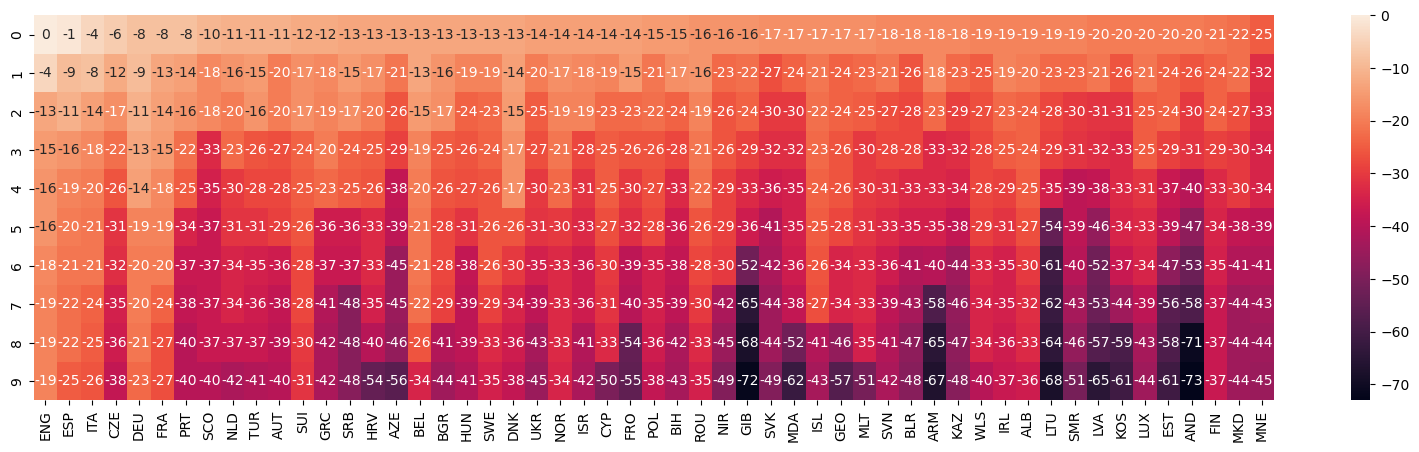

In [482]:
fig, ax = plt.subplots(figsize = (20,5))
sns.heatmap(gaps_to_1st(table)[:10].astype(int), annot = True)

<Axes: >

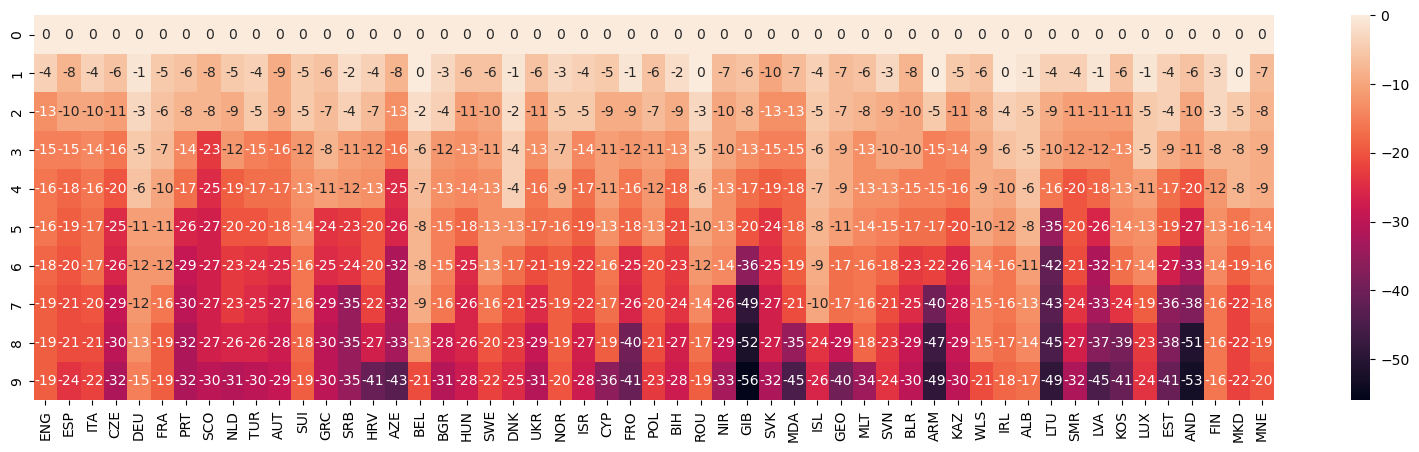

In [484]:
fig, ax = plt.subplots(figsize = (20,5))
sns.heatmap(gaps_to_1st(table, False)[:10].astype(int), annot = True)

In [478]:
table[table.country == 'DEU'][:20]

,name,points,country
8,Bayer Leverkusen,97,DEU
15,Bayern München,96,DEU
18,Borussia Dortmund,95,DEU
22,RB Leipzig,94,DEU
27,1. FC Union Berlin,94,DEU
86,VfB Stuttgart,89,DEU
104,Eintracht Frankfurt,88,DEU
106,VfL Wolfsburg,88,DEU
121,SC Freiburg,87,DEU
150,Bor. Mönchengladbach,85,DEU


In [485]:
league_table = to.league_table()

In [490]:
league_table[:20]

,team,country,seed,sonneborn-berger,points
0,Manchester City,ENG,1,10026,108
1,Real Madrid,ESP,2,9777,107
2,Liverpool FC,ENG,4,9271,104
3,Inter,ITA,3,9096,104
4,AC Sparta Praha,CZE,43,8459,102
5,Bayer Leverkusen,DEU,6,8766,100
6,Paris Saint-Germain,FRA,8,8577,100
7,AC Milan,ITA,20,8469,100
8,Sporting CP,PRT,17,8338,100
9,Bayern München,DEU,7,8721,99


In [492]:
league_table.drop_duplicates('country')

,team,country,seed,sonneborn-berger,points
0,Manchester City,ENG,1,10026,108
1,Real Madrid,ESP,2,9777,107
3,Inter,ITA,3,9096,104
4,AC Sparta Praha,CZE,43,8459,102
5,Bayer Leverkusen,DEU,6,8766,100
6,Paris Saint-Germain,FRA,8,8577,100
8,Sporting CP,PRT,17,8338,100
11,Rangers FC,SCO,48,7731,98
14,PSV Eindhoven,NLD,11,8072,97
15,RB Salzburg,AUT,45,7674,97


# Fixtures

In [491]:
to.fixtures_df('AC Sparta Praha')

,Home,score1,score2,Away,Result,Matchday
302,AC Sparta Praha,1.0,0.0,SK Motorlet Praha,AC Sparta Praha,1
978,AC Sparta Praha,1.0,0.0,SK Austria Klagenfurt,AC Sparta Praha,2
2112,Bohemians Praha 1905,0.0,1.0,AC Sparta Praha,AC Sparta Praha,3
2746,FK Isloch Minsk,0.0,1.0,AC Sparta Praha,AC Sparta Praha,4
3919,AC Sparta Praha,1.0,0.0,Viktoria Plzen,AC Sparta Praha,5
4551,Sturm Graz,1.0,0.0,AC Sparta Praha,Sturm Graz,6
5816,AC Sparta Praha,1.0,0.0,1. FC Slovácko,AC Sparta Praha,7
6391,SK Brann,0.0,1.0,AC Sparta Praha,AC Sparta Praha,8
7488,AC Sparta Praha,1.0,0.0,Slavia Praha,AC Sparta Praha,9
8156,AC Sparta Praha,1.0,0.0,Manchester City,AC Sparta Praha,10


In [359]:
to.fixtures_df()[to.fixtures_df().Matchday == 48]

,Home,score1,score2,Away,Result,Matchday
37451,Manchester City,1.0,0.0,Inter,Manchester City,48
37452,Fenerbahçe,0.0,1.0,Galatasaray,Galatasaray,48
37453,Slavia Praha,1.0,0.0,AC Sparta Praha,Slavia Praha,48
37454,Maccabi Tel Aviv,0.5,0.5,Maccabi Haifa,draw,48
37455,TSC Backa Topola,0.5,0.5,Partizan,draw,48
37456,Molde FK,0.5,0.5,FK Bodø/Glimt,draw,48
37457,CFR Cluj,1.0,0.0,Rapid Bucuresti,CFR Cluj,48
37458,Torpedo Kutaisi,0.0,1.0,Dinamo Batumi,Dinamo Batumi,48
37459,KR Reykjavík,1.0,0.0,Breiðablik,KR Reykjavík,48
37460,Víkingur Reykjavík,1.0,0.0,KA Akureyri,Víkingur Reykjavík,48


In [404]:
league_table[league_table.country == 'ESP'][:20]

,team,country,seed,sonneborn-berger,points,position-seed delta
2,Real Madrid,ESP,2,9170,103,1
8,Atlético Madrid,ESP,9,8285,100,0
67,Real Sociedad,ESP,15,7315,90,53
69,Valencia CF,ESP,60,6916,90,10
91,Girona FC,ESP,22,7172,88,70
129,Real Betis,ESP,47,6615,86,83
163,RCD Mallorca,ESP,76,5841,84,88
191,FC Barcelona,ESP,12,6814,82,180
193,Athletic Bilbao,ESP,18,6707,82,176
214,Villarreal CF,ESP,50,5963,81,165


In [355]:
league_table.drop_duplicates('country')

,team,country,seed,sonneborn-berger,points
0,Manchester City,ENG,1,9819,113
1,Inter,ITA,3,8717,105
2,Real Madrid,ESP,2,9170,103
3,Sporting CP,PRT,17,8486,103
5,PSV Eindhoven,NLD,11,8402,101
6,Paris Saint-Germain,FRA,8,8062,101
7,RB Leipzig,DEU,13,8510,100
9,Galatasaray,TUR,34,6775,100
11,Slavia Praha,CZE,31,7910,97
12,Shakhtar Donetsk,UKR,61,7138,97


# Position-Seed Delta

In [372]:
deltas = []

for idx, row in league_table.iterrows():
    team = row.name
    position = idx + 1
    seed = row.seed
    delta = position - seed
    deltas.append(delta)
    
league_table['position-seed delta'] = deltas 

C:\Users\Usamah\AppData\Local\Temp\ipykernel_4072\306545903.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = league_table.groupby('country').mean()


<Axes: xlabel='margins', ylabel='position-seed delta'>

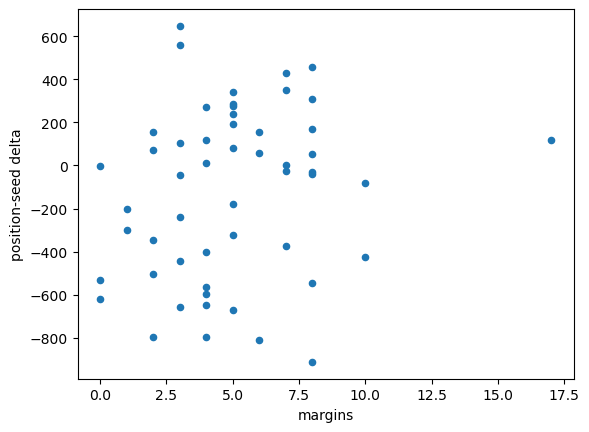

In [380]:
# Examining the relationship between league winning margin and average position-seed delta
league_tables = [league_table[league_table.country == country].reset_index(drop=True) for country in league_table.country.drop_duplicates()]

winning_margin_dict = {}
for table in league_tables:
    if len(table) > 1:
        delta = table['points'][0] - table['points'][1]
        winning_margin_dict[table.country[0]] = delta
    
df = league_table.groupby('country').mean()
margins = []
for idx, row in df.iterrows():
    try:
        margins.append(winning_margin_dict[idx])
    except:
        margins.append(None)

df['margins'] = margins

df.dropna(how = 'any').plot(x = 'margins', y = 'position-seed delta',  kind = 'scatter')

In [381]:
df.sort_values(by = 'margins', ascending = False)

,position-seed delta,margins
country,,
ENG,116.632000,17
ARM,-425.571429,10
AZE,-81.615385,10
NLD,-38.687500,8
AUT,-32.609756,8
HUN,310.400000,8
BGR,167.862069,8
UKR,458.550000,8
MDA,-547.461538,8


C:\Users\Usamah\AppData\Local\Temp\ipykernel_4072\3719136059.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))


<Axes: xlabel='country'>

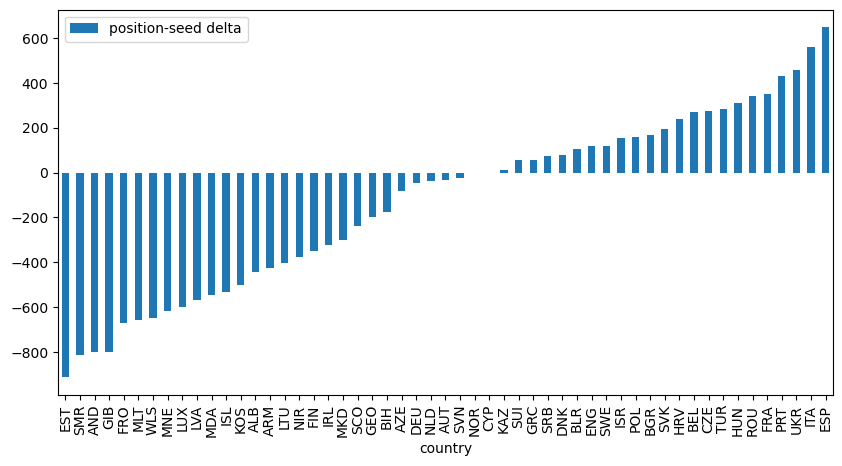

In [382]:
league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))

<Axes: xlabel='country'>

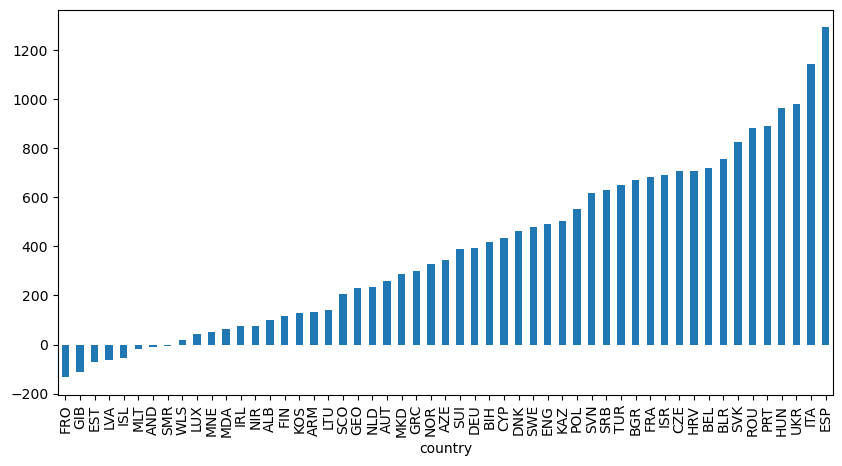

In [383]:
league_table.groupby('country')['position-seed delta'].max().sort_values().plot.bar(figsize = (10,5))

# Byes

In [486]:
teams_df = to.teams_df()
teams_df[teams_df.byes > 1].sort_values('byes', ascending = False)[['name','points','country','byes']]

,name,points,country,byes
1593,Oxford City,43,ENG,9
1591,Chester FC,43,ENG,8
1617,Maidstone United,42,ENG,6
318,FK Liepaja,77,LVA,4
1582,Dinamo-Auto,43,MDA,4
...,...,...,...,...
632,NK GOŠK Gabela,64,BIH,2
640,FK Grbalj Radanovici,64,MNE,2
675,OFK Petrovac,63,MNE,2
747,Hapoel Ramat Gan,61,ISR,2


In [487]:
teams_df[teams_df.country == 'ENG']

,name,seed,points,opponents,home_away,home_away_restriction,home_away_gap,byes,sonneborn-berger,elo,country
0,Manchester City,1,108,"[Wrexham AFC, HNK Rijeka, Nottingham Forest, R...","[home, home, away, home, away, home, away, hom...",None,1,0,10026,2386,ENG
3,Liverpool FC,4,104,"[Crewe Alexandra, BK Häcken, Fulham FC, Rander...","[home, home, away, away, home, home, away, hom...",None,1,0,9271,2266,ENG
20,Arsenal FC,5,95,"[Morecambe FC, FC Utrecht, Burnley FC, CSKA So...","[home, home, away, home, away, home, away, hom...",None,1,0,8606,2232,ENG
42,Tottenham Hotspur,24,93,"[Cambridge United, Heart of Midlothian, Sheffi...","[home, home, away, away, home, home, away, hom...",None,1,0,7879,2096,ENG
53,Brighton & Hove Albion,21,92,"[Shrewsbury Town, Pogon Szczecin, Ipswich Town...","[home, home, away, away, home, home, away, hom...",None,1,0,7824,2102,ENG
...,...,...,...,...,...,...,...,...,...,...,...
1591,Chester FC,1697,43,"[Bristol Rovers, Cheltenham Town, Swindon Town...","[home, away, away, home, away, home, home, awa...",None,-1,8,871,982,ENG
1593,Oxford City,1710,43,"[Wigan Athletic, Plymouth Argyle, Derby County...","[home, home, away, home, away, away, home, hom...",home only,-2,9,800,970,ENG
1594,Weymouth FC,1739,43,"[Blackburn Rovers, Cambridge United, Doncaster...","[home, away, away, home, home, away, away, hom...",None,-1,2,1703,929,ENG
1617,Maidstone United,1724,42,"[Burton Albion, Mansfield Town, Forest Green R...","[home, away, home, away, home, away, away, hom...",None,-1,6,1066,949,ENG


# Points Distribution

<Axes: >

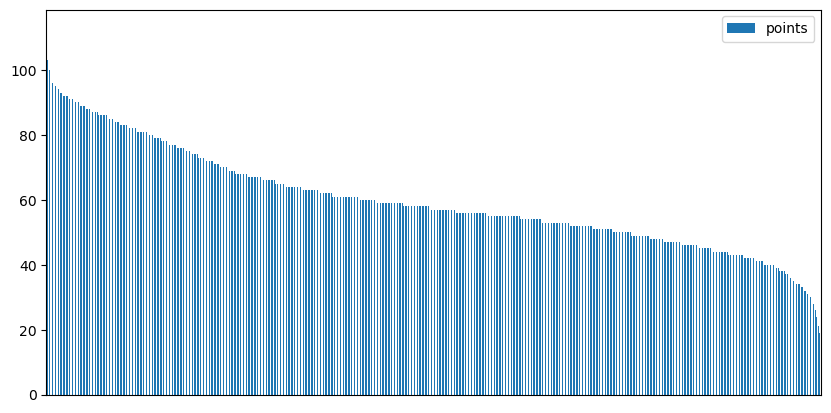

In [390]:
league_table.plot.bar(y = 'points', xticks = [], figsize = (10,5))

<Axes: ylabel='Frequency'>

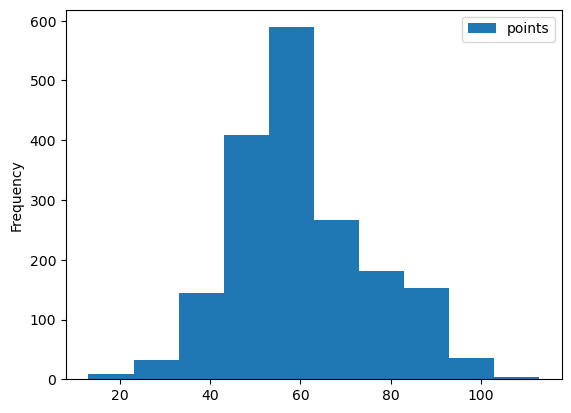

In [391]:
league_table.plot.hist(y = 'points')

<Axes: xlabel='country'>

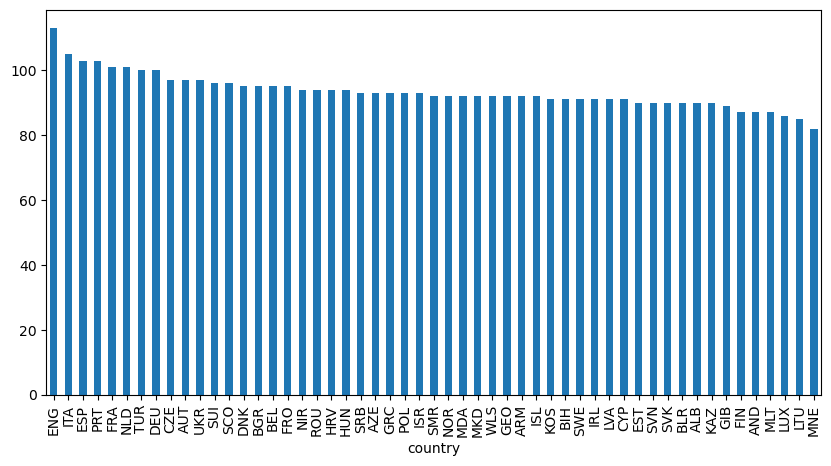

In [393]:
league_table.groupby('country')['points'].max().sort_values(ascending = False).plot.bar(figsize = (10,5))

In [394]:
league_table.drop_duplicates('country')

,team,country,seed,sonneborn-berger,points,position-seed delta
0,Manchester City,ENG,1,9819,113,0
1,Inter,ITA,3,8717,105,-1
2,Real Madrid,ESP,2,9170,103,1
3,Sporting CP,PRT,17,8486,103,-13
5,PSV Eindhoven,NLD,11,8402,101,-5
6,Paris Saint-Germain,FRA,8,8062,101,-1
7,RB Leipzig,DEU,13,8510,100,-5
9,Galatasaray,TUR,34,6775,100,-24
11,Slavia Praha,CZE,31,7910,97,-19
12,Shakhtar Donetsk,UKR,61,7138,97,-48


# Save/Load

In [396]:
import pickle

with open ('TournamentV6_sample.pickle','wb') as file:
    pickle.dump(to, file)

PicklingError: Can't pickle <class '__main__.Tournament'>: it's not the same object as __main__.Tournament

In [397]:
to

In [8]:
import pickle

with open ('TournamentV5_sample.pickle','rb') as file:
    to = pickle.load(file)

# Upset Check

In [398]:
fixtures = to.fixtures_df()

upset_list = []

for idx, row in fixtures.iterrows():
    teams, result = [row.Home, row.Away], row.Result
    seeds = [to.team_dict[x]['seed'] for x in teams]
    
    home_advantage = seeds[0] < seeds[1]
    home_result = result == teams[0]
    
    if result == 'draw':
        text = 'draw'
    else:
        if home_advantage == home_result:
            text = 'hold'
        else:
            text = 'upset'
    upset_list.append(text)

In [401]:
fixtures['upset?'] = upset_list

rate_list = []
for n in range(1, to.matchday + 1):
    mask = fixtures['Matchday'] == n
    result_rates = fixtures[mask].value_counts(subset = 'upset?')/sum(mask)
    rate_list.append(result_rates)

<Axes: >

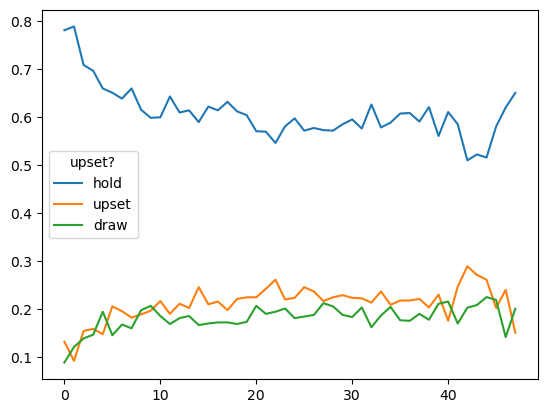

In [402]:
pd.DataFrame(rate_list).plot()

In [10]:
league_table = to.league_table()

KeyboardInterrupt: 

In [14]:
league_table.drop_duplicates('country')

,team,country,seed,sonneborn-berger,points
0,Manchester City,ENG,1,7344,96
1,Inter,ITA,3,7074,95
2,Paris Saint-Germain,FRA,8,7026,95
4,Bayern München,DEU,7,6987,91
5,Atlético Madrid,ESP,9,6810,90
6,Galatasaray,TUR,34,6498,90
7,Slavia Praha,CZE,31,6240,89
9,PSV Eindhoven,NLD,11,6412,88
10,FC Porto,PRT,16,6488,87
11,RB Salzburg,AUT,45,6266,87


In [27]:
league_table[league_table.country == 'ARM']

,team,country,seed,sonneborn-berger,points
124,Pyunik FC,ARM,615,4641,78
139,FC Ararat-Armenia,ARM,794,4073,77
151,FC Urartu,ARM,1069,3899,76
217,FC Alashkert,ARM,1144,3592,73
307,Gandzasar Kapan,ARM,1447,3432,70
389,Mika FC,ARM,1403,3205,67
526,FC Noah,ARM,1242,3099,64
1273,FC Ararat,ARM,1523,2370,52
1424,BKMA Yerevan,ARM,1571,2235,48
1541,FK Van,ARM,1620,2179,44


In [414]:
def gaps_to_1st(league_table, continent = True):

    df = pd.DataFrame()

    for country in league_table.country.drop_duplicates():
        points_series = league_table[league_table.country == country].points.reset_index(drop = True)
        if continent == True:
            gap_to_1st = points_series - league_table.points[0]
        else:
            gap_to_1st = points_series - points_series[0]
        df[country] = gap_to_1st

    return df

In [347]:
gaps_to_1st_continent = pd.DataFrame()

for country in league_table.country.drop_duplicates():
    points_series = league_table[league_table.country == country].points.reset_index(drop = True)
    gap_to_1st = points_series - league_table.points[0]
    gaps_to_1st_continent[country] = gap_to_1st

gaps_to_1st_continent

,ENG,ITA,ESP,PRT,NLD,FRA,DEU,TUR,CZE,UKR,...,ALB,BLR,KAZ,GIB,FIN,MLT,AND,LUX,LTU,MNE
0,0,-8,-10,-10,-12,-12,-13,-13,-16,-16,...,-23,-23,-23,-24,-26,-26,-26,-27,-28,-31
1,-17,-11,-13,-17,-20,-19,-16,-18,-21,-24,...,-26,-26,-27,-28,-28,-29,-28,-31,-32,-31
2,-24,-19,-23,-19,-22,-21,-17,-32,-27,-31,...,-32,-31,-27,-31,-36,-32,-29,-31,-32,-35
3,-25,-21,-23,-23,-24,-21,-19,-33,-27,-36,...,-36,-34,-32,-37,-37,-32,-30,-32,-33,-37
4,-25,-24,-25,-27,-30,-26,-22,-33,-29,-37,...,-38,-34,-32,-41,-38,-35,-47,-34,-40,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,-68,NaN,NaN,NaN,NaN,NaN,-61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,-69,NaN,NaN,NaN,NaN,NaN,-61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,-69,NaN,NaN,NaN,NaN,NaN,-61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,-69,NaN,NaN,NaN,NaN,NaN,-61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
import matplotlib.pyplot as plt

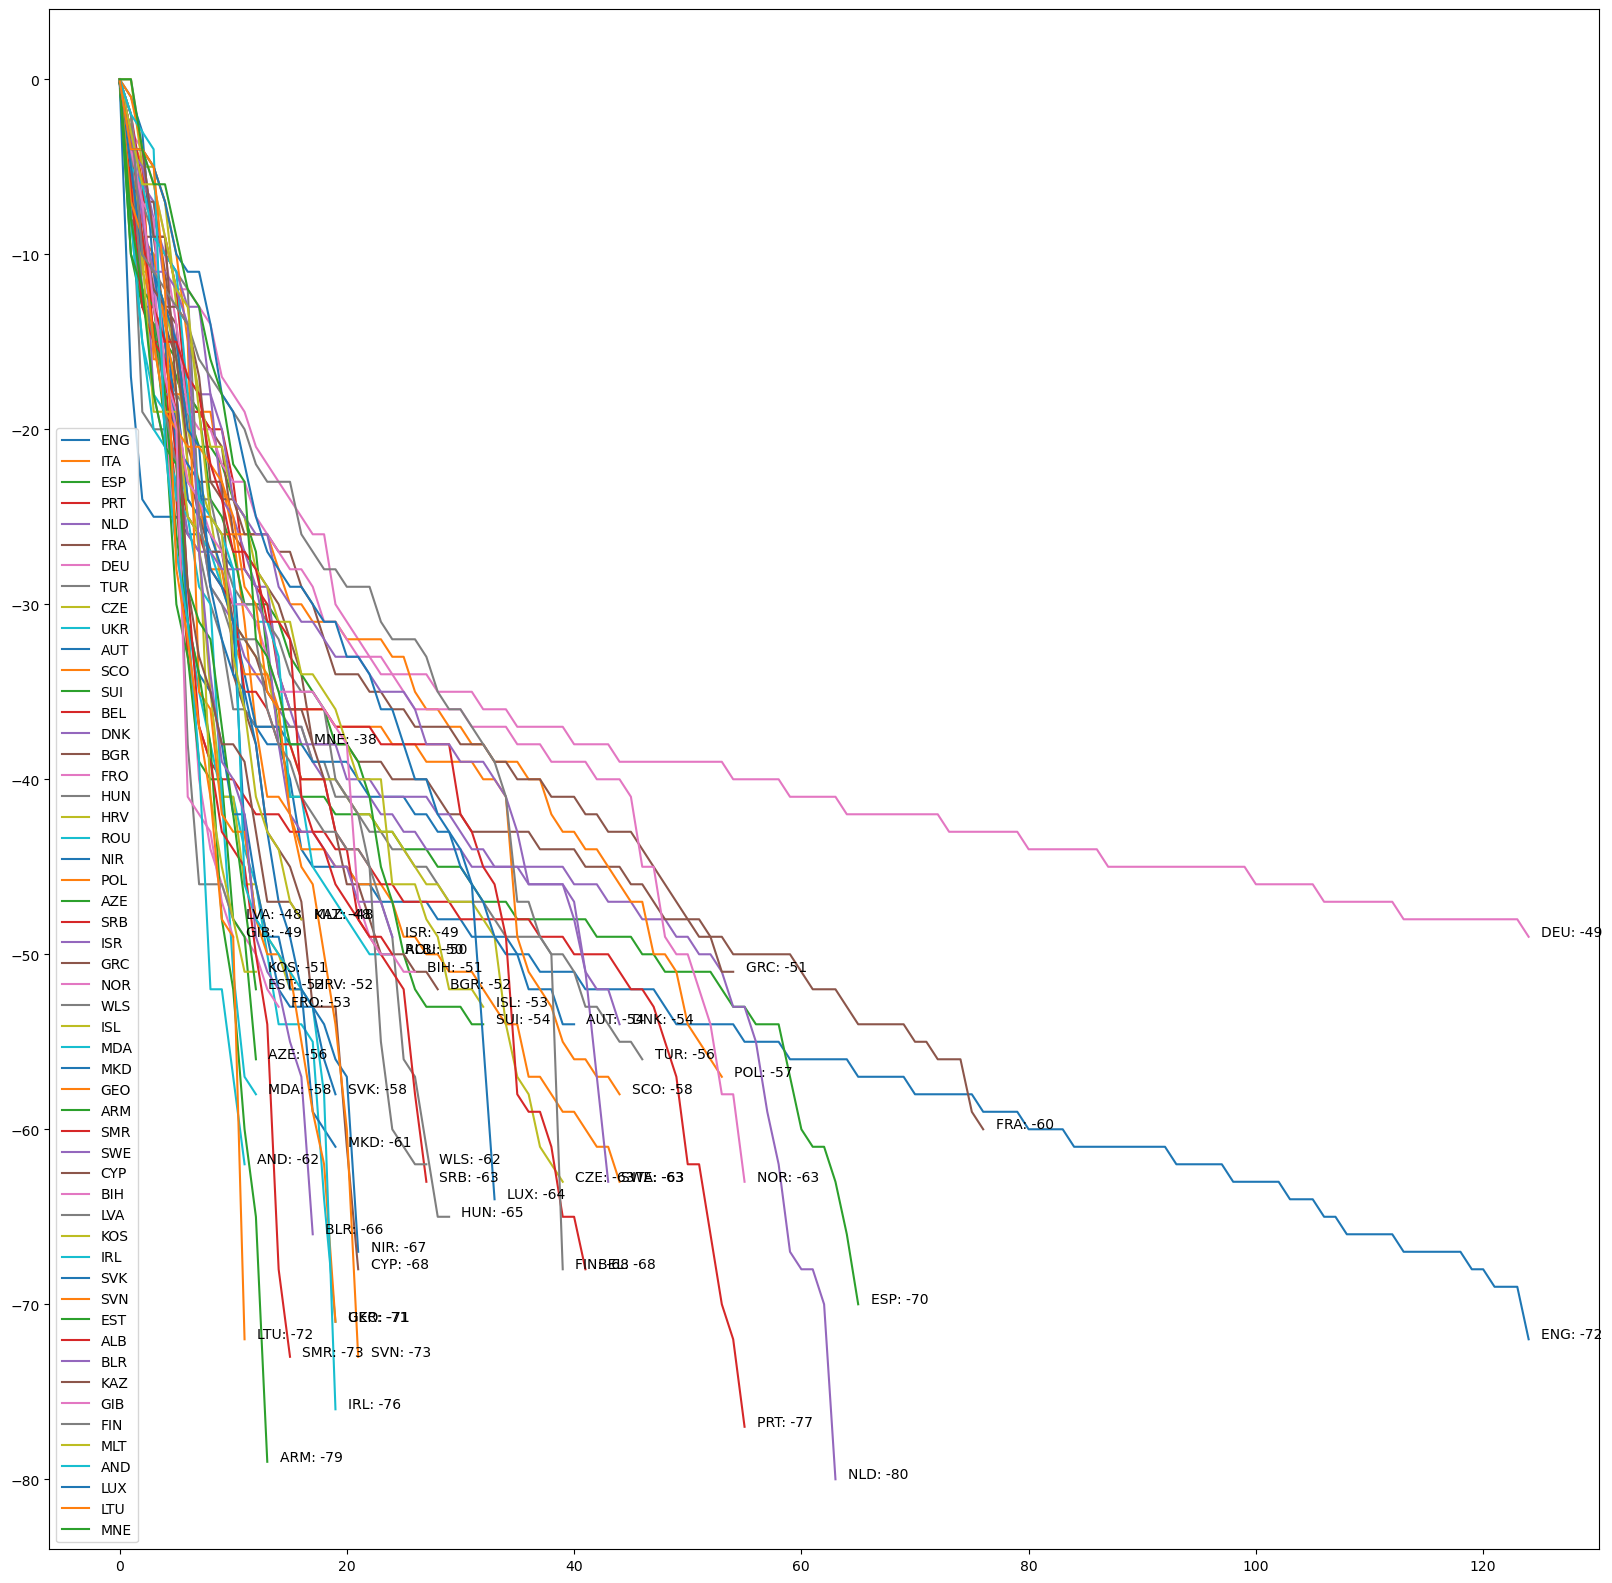

In [350]:
ax = gaps_to_1st.plot.line(figsize = (20,20))

for col in gaps_to_1st.columns[:]:
    last_x = len(gaps_to_1st[col].dropna())
    last_y = gaps_to_1st[col].iloc[last_x - 1]
    plt.annotate(f'{col}: {last_y}', xy=(last_x, last_y), xytext=(1, 1), textcoords = 'offset pixels')


In [ ]:
import seaborn as sns

<Axes: >

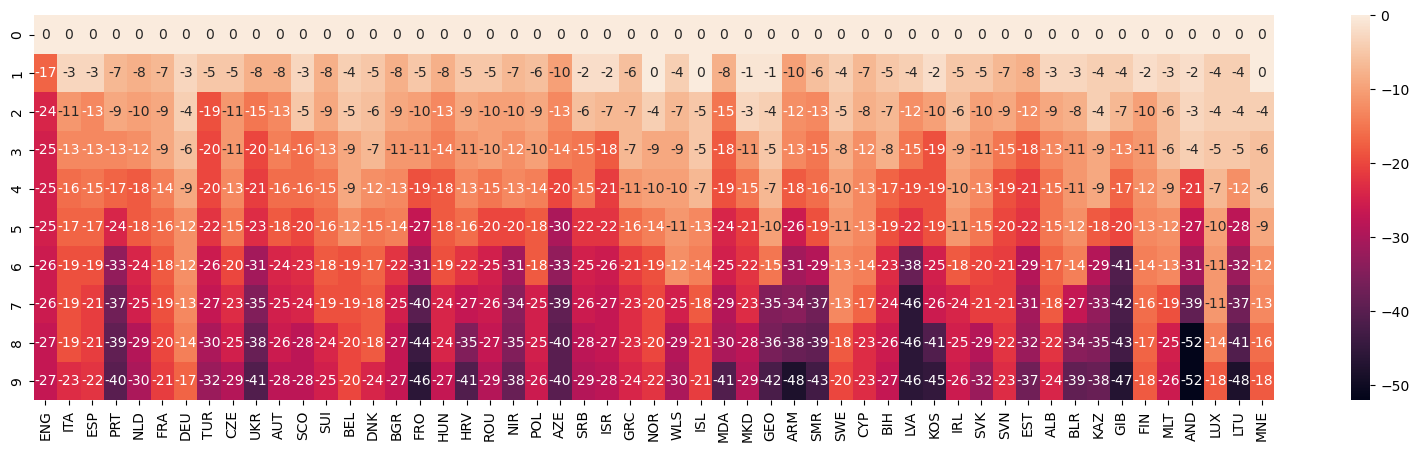

In [351]:
fig, ax = plt.subplots(figsize = (20,5))
sns.heatmap(gaps_to_1st[:10].astype(int), annot = True)

<Axes: >

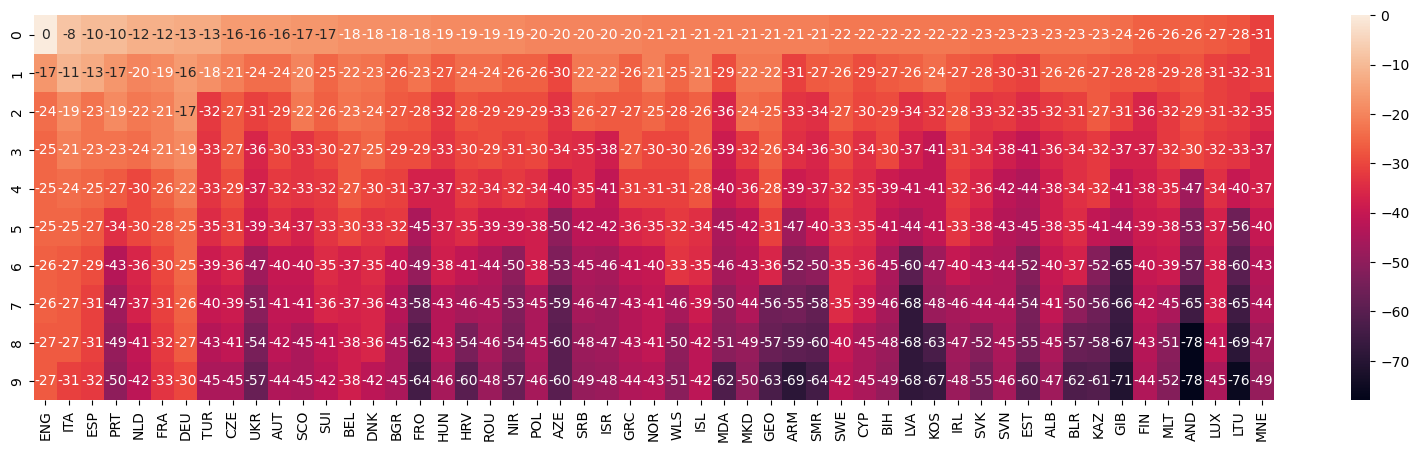

In [348]:
fig, ax = plt.subplots(figsize = (20,5))
sns.heatmap(gaps_to_1st_continent[:10].astype(int), annot = True)

In [105]:
league_table[league_table.country == 'SVN']

,team,country,seed,sonneborn-berger,points
36,NK Celje,SVN,224,5375,84
260,NK Maribor,SVN,420,4102,71
304,NK Bravo,SVN,631,3761,70
371,Olimpija Ljubljana,SVN,332,4187,67
388,NK Domžale,SVN,757,3256,67
390,NK Krka,SVN,962,3159,67
418,NK Šmartno,SVN,862,3443,66
519,FC Koper,SVN,620,3437,64
521,NŠ Mura,SVN,638,3218,64
833,NK Aluminij,SVN,1038,2751,59


In [236]:
gap_cutoff = 9
filter_ = 'country'

In [246]:
teams_df = to.teams_df()
continent_leader = teams_df.points[0]

top_teams_count = sum(continent_leader - teams_df.points < gap_cutoff)
if top_teams_count % 2 == 1:
    top_teams_count += 1

top_tier_teams = teams_df[:top_teams_count]
low_tier_teams = teams_df[top_teams_count:]

national_leaders = list(teams_df.drop_duplicates(filter_).points)

filter_categories =  teams_df[filter_].drop_duplicates().reset_index(drop = True)
teams_divided = [low_tier_teams[low_tier_teams[filter_] == x].reset_index(drop=True) for x in filter_categories]

for idx, table in enumerate(teams_divided):
    allocation = sum(national_leaders[idx] - table.points < gap_cutoff)
    if allocation % 2 == 1:
        if (filter_categories[idx] not in top_tier_teams[filter_].values) & (allocation == 1):
            allocation = 0
        else:
            allocation += 1
    teams_divided[idx] = table[:allocation].reset_index(drop = True)

In [292]:
teams_divided[52]

,name,seed,points,opponents,home_away,home_away_restriction,home_away_gap,byes,sonneborn-berger,elo,country
0,SP Tre Fiori,1769,74,"[AC Juvenes/Dogana, SS Pennarossa, FC Fiorenti...","[home, home, away, home, away, home, away, awa...",away only,1,0,3752,848,SMR
1,SS Cosmos,1771,74,"[SP Cailungo, SC Faetano, AC Juvenes/Dogana, S...","[away, home, home, away, home, away, home, hom...",None,1,0,3711,843,SMR
2,SP Tre Penne,1750,72,"[AC Libertas, BSC Young Boys, SS Murata, San M...","[home, home, away, home, away, home, away, awa...",home only,1,0,3650,900,SMR
3,SP La Fiorita,1723,71,"[SS San Giovanni, AC Sparta Praha, San Marino ...","[home, home, away, home, away, home, away, awa...",None,-1,0,3327,951,SMR
4,SS Virtus,1767,71,"[FC Domagnano, SP Cailungo, SS Pennarossa, Ser...","[home, away, away, home, home, away, home, awa...",away only,1,0,3286,864,SMR
5,SS Folgore/Falciano,1805,61,"[San Marino Academy, FC Domagnano, SP Cailungo...","[away, home, home, away, home, away, home, hom...",away only,1,0,2586,630,SMR


In [ ]:
print(len)

In [252]:
for idx, category in enumerate(filter_categories):
    if category not in top_tier_teams[filter_].values:
        print(len(teams_divided[idx]))

56
41
42
25
44
20
20
33
55
28
17
45
13
29
25
22
22
27
17
45
30
18
56
54
33
20
20
13
28
11
22
17
40
20
25
15
17
11
14
13
12
12
13
34
16


In [222]:
'ENG' in top_tier_teams[filter_].values

True

In [235]:
top_tier_teams

,name,seed,points,opponents,home_away,home_away_restriction,home_away_gap,byes,sonneborn-berger,elo,country
0,Manchester City,1,96,"[Exeter City, Floriana FC, Ipswich Town, Coven...","[home, home, away, away, home, home, away, hom...",None,1,0,7344,2386,ENG
1,Inter,3,95,"[SPAL 2013 Ferrara, NK Radomlje, US Salernitan...","[home, home, away, away, home, home, away, hom...",None,1,0,7074,2314,ITA
2,Paris Saint-Germain,8,95,"[SO Cholet, Rosenborg BK, Havre AC, Kauno Žalg...","[home, home, away, home, away, home, away, awa...",away only,1,0,7026,2216,FRA
3,Arsenal FC,5,92,"[Eastleigh FC, FC Santa Coloma, Leeds United, ...","[home, away, home, home, away, home, away, hom...",None,1,0,6870,2232,ENG
4,Bayern München,7,91,"[Bor. Mönchengladbach II, Spartak Trnava, SV S...","[home, home, away, home, away, home, away, awa...",None,1,0,6987,2221,DEU
...,...,...,...,...,...,...,...,...,...,...,...
216,FC Flora,1281,73,"[Harju JK, Bor. Mönchengladbach, JK Tammeka, T...","[away, home, away, home, home, away, away, hom...",None,-1,2,3607,1279,EST
217,Gzira United,1354,73,"[Zebbug Rangers, Pietá Hotspurs, St. Lucija FC...","[away, home, home, away, away, home, away, hom...",None,1,2,3634,1249,MLT
218,Coleraine FC,1414,73,"[Newry City FC, Institute FC Drumahoe, Loughga...","[away, home, home, away, home, away, away, hom...",away only,1,0,3740,1217,NIR
219,Sliema Wanderers,1473,73,"[St. Lucija FC, Zejtun Corinthians, Sirens FC,...","[away, home, home, away, home, away, home, hom...",None,-1,2,3752,1179,MLT


In [172]:
row['name'] == other_teams[category_no].name[0]

True

In [177]:
other_teams[category_no].drop(0)

KeyError: '[0] not found in axis'

In [161]:
filter_categories[filter_categories == 'ITA'].index[0]

1

In [153]:
teams_df.name.isin(top_tier_teams.name) == False

0       False
1       False
2       False
3       False
4       False
        ...  
1817     True
1818     True
1819     True
1820     True
1821     True
Name: name, Length: 1822, dtype: bool

In [143]:
other_teams[10]

,name,seed,points,opponents,home_away,home_away_restriction,home_away_gap,byes,sonneborn-berger,elo,country
0,Royal Antwerp FC,89,71,"[KRC Mechelen, Shamrock Rovers, SK Deinze, Spo...","[home, away, home, away, home, home, away, hom...",None,1,0,4684,1913,BEL
1,Cercle Brugge,160,71,"[Standard Liège II, Víkingur Reykjavík, KV Mec...","[away, home, home, away, away, home, home, awa...",None,-1,0,4600,1807,BEL
2,KVC Westerlo,250,66,"[Lierse Kempenzonen, Hoogstraten VV, KRC Harel...","[home, away, home, away, away, home, home, awa...",None,1,0,3931,1710,BEL
3,Sint-Truidense VV,225,63,"[SK Deinze, Royal Francs Borains, KRC Genk, SK...","[home, away, home, away, home, home, away, hom...",None,1,0,3609,1735,BEL
4,Standard Liège,263,63,"[KRC Genk II, KFC Dessel Sport, Union Saint-Gi...","[away, home, home, away, home, away, away, hom...",None,1,0,3765,1701,BEL
5,Oud-Heverlee Leuven,274,63,"[Royal Francs Borains, KSV Oudenaarde, Hoogstr...","[away, home, home, away, home, away, home, hom...",None,1,0,3573,1696,BEL


In [ ]:
# Create fixtures
self.create_fixtures(top_tier_teams, avoid_same_country = 0)
for teams in other_teams:
    self.create_fixtures(teams)

In [142]:
league_table[league_table.country == 'NOR']

,team,country,seed,sonneborn-berger,points
54,FK Bodø/Glimt,NOR,71,5741,82
116,Molde FK,NOR,130,5260,78
178,SK Brann,NOR,149,4794,74
292,Lillestrøm SK,NOR,342,4308,70
294,Tromsø IL,NOR,201,4267,70
370,Viking FK,NOR,226,4246,67
409,Rosenborg BK,NOR,292,3936,66
508,FK Haugesund,NOR,419,3723,64
538,Strømsgodset IF,NOR,347,3932,63
547,Hamarkameratene,NOR,476,3718,63
